# **REAL ESTATE RISK PREDICTION**

### **Data Description**

**CRIM**: per capita crime rate by town

**ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.

**INDUS**: proportion of non-retail business acres per town

**CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

**NOX**: nitric oxides concentration (parts per 10 million)

**RM**: average number of rooms per dwelling

**AGE**: proportion of owner-occupied units built prior to 1940

**DIS**: weighted distances to ﬁve Boston employment centers

**RAD**: index of accessibility to radial highways

**TAX**: full-value property-tax rate per $10,000

**PTRATIO**: pupil-teacher ratio by town 12. 

**B**: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 13.

**LSTAT**: % lower status of the population

**MEDV**: Median value of owner-occupied homes in $1000s

## **Import Libraries**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

## **Load Data**

In [32]:
file_path = "data.csv"  
df = pd.read_csv(file_path)

print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


## **Define Risk Categories(Target variable)**

In [33]:
# Create Risk Categories
df['RISK'] = pd.qcut(df['MEDV'], q=[0, 0.25, 0.75, 1], labels=['High', 'Moderate', 'Low'])
print(df[['MEDV', 'RISK']].head())

   MEDV      RISK
0  24.0  Moderate
1  21.6  Moderate
2  34.7       Low
3  33.4       Low
4  36.2       Low


## **Data Cleaning & Preprocessing**

**Check for Missing Values**

In [34]:
print(df.isnull().sum())  # No missing values in Boston dataset

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         5
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
RISK       0
dtype: int64


**Outlier Detection & Handling**

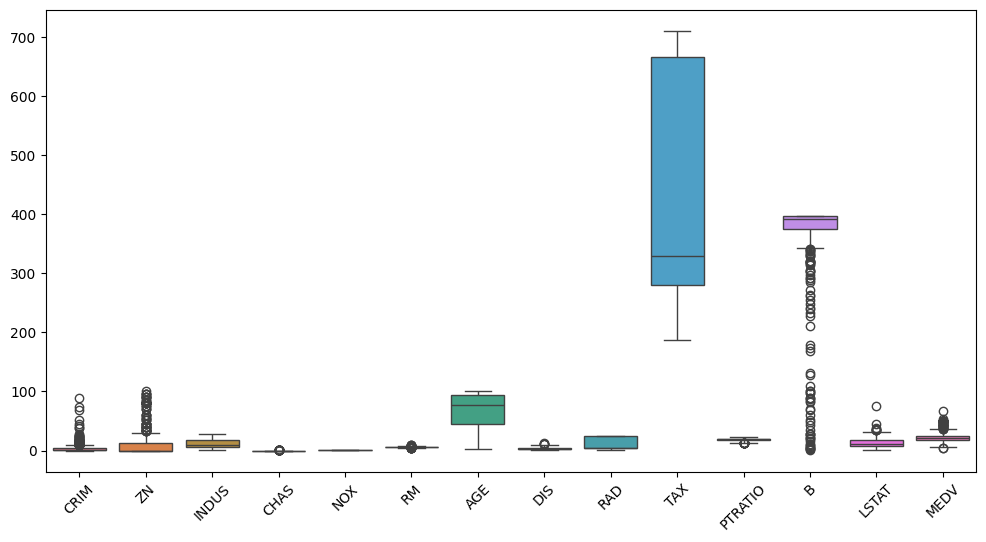

In [35]:
# Visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop('RISK', axis=1))
plt.xticks(rotation=45)
plt.show()


In [36]:

# Winsorization (capping outliers)
for col in df.select_dtypes(include=['float64', 'int64']):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

**Feature Scaling**

In [37]:
scaler = StandardScaler()
X = df.drop('RISK', axis=1)
y = df['RISK']
X_scaled = scaler.fit_transform(X)

## **Exploratory Data Analysis(EDA)**

**Risk Distribution**

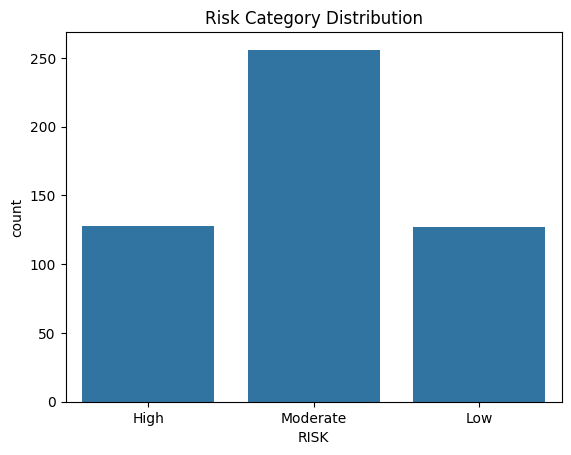

In [38]:
sns.countplot(x=df['RISK'])
plt.title("Risk Category Distribution")
plt.show()

**Correlation Heatmap**

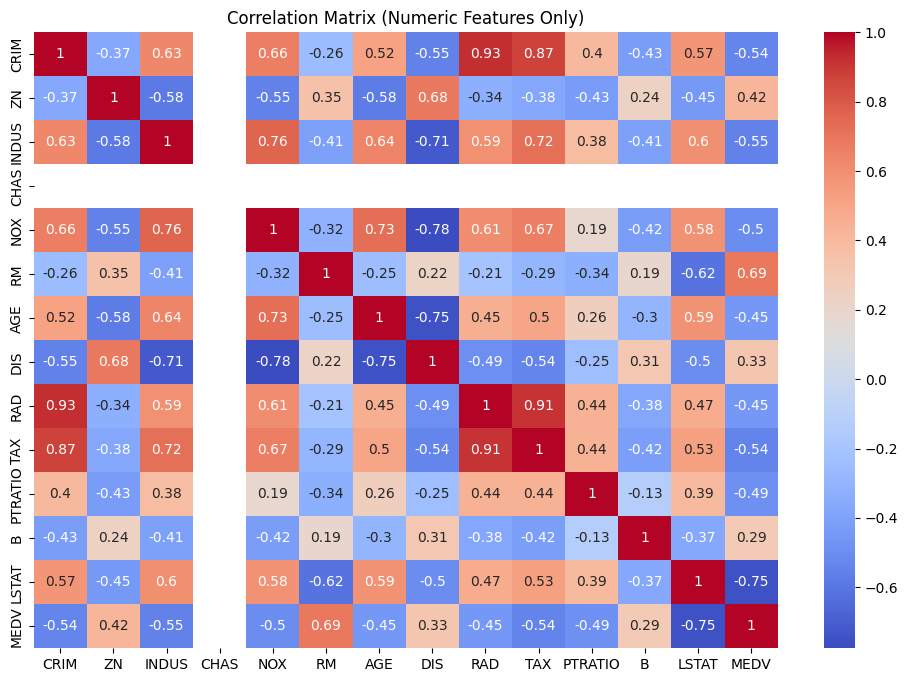

In [39]:
# Calculate correlation only for numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

**Feature Importance(Random Forest)**

In [40]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10]
}

# Create and fit GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5
)
grid_search.fit(X, y)

# Now you can use best_model
best_model = grid_search.best_estimator_
importance = best_model.feature_importances_

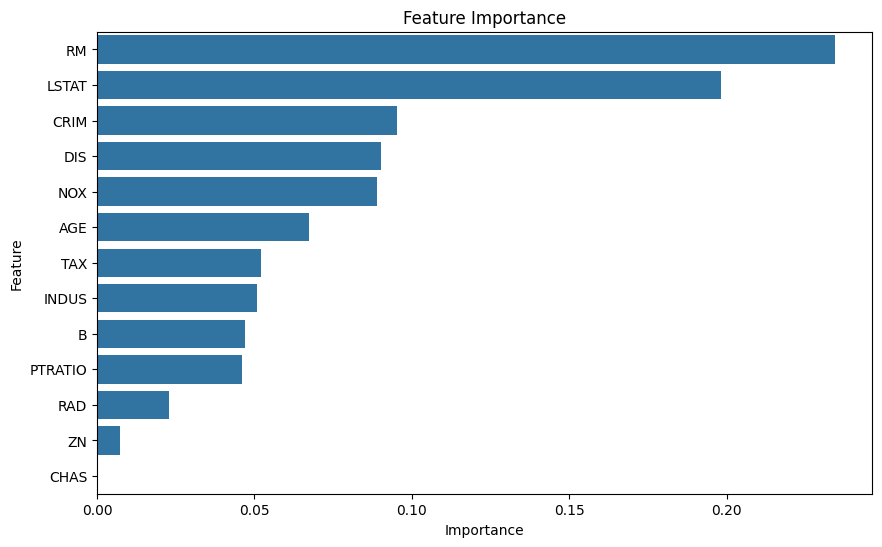

In [41]:


# 2. Prepare features (X) and target (y)
X = df.drop(['MEDV', 'RISK'], axis=1)  # Features
y = df['RISK']                         # Target

# 3. Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# 4. Get feature importances
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# 5. Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance")
plt.show()

## **Feature Engineering**


**Interaction Features**

In [42]:
df['RM_TAX_interaction'] = df['RM'] * df['TAX']  # Rooms vs Tax
df['NOX_DIS_interaction'] = df['NOX'] * df['DIS']  # Pollution vs Distance

**Binning Continuous Variables**

In [43]:
df['AGE_binned'] = pd.cut(df['AGE'], bins=3, labels=['New', 'Medium', 'Old'])
df = pd.get_dummies(df, columns=['AGE_binned'], drop_first=True)

## **Model Training**

**Train-Test Split**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

**Handling CLass Imbalance(SMOTE)**

In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


# Impute missing values (recommended)
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X = df.drop(['MEDV', 'RISK'], axis=1)
y = df['RISK']
X_imputed = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

#  Apply SMOTE (now that there are no NaN values)
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#  Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

#  Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.80      0.76      0.78        42
         Low       0.82      0.82      0.82        28
    Moderate       0.85      0.87      0.86        84

    accuracy                           0.83       154
   macro avg       0.82      0.82      0.82       154
weighted avg       0.83      0.83      0.83       154



In [46]:
print(pd.DataFrame(X_imputed).isnull().sum())  # Should show 0 NaN values

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
dtype: int64


**MODEL SELECTION**

In [47]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# 1. Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# 2. Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_smote)
y_test_encoded = le.transform(y_test)

# 3. Updated models dictionary
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=5000)  # Removed multi_class
}

# 4. Train and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train_encoded)
    y_pred_encoded = model.predict(X_test_scaled)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    print(f"\n--- {name} ---")
    print("Test classes:", np.unique(y_test))
    print("Pred classes:", np.unique(y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))


--- Random Forest ---
Test classes: ['High' 'Low' 'Moderate']
Pred classes: ['High' 'Low' 'Moderate']
              precision    recall  f1-score   support

        High       0.80      0.76      0.78        42
         Low       0.81      0.79      0.80        28
    Moderate       0.85      0.88      0.87        84

    accuracy                           0.83       154
   macro avg       0.82      0.81      0.82       154
weighted avg       0.83      0.83      0.83       154


--- XGBoost ---
Test classes: ['High' 'Low' 'Moderate']
Pred classes: ['High' 'Low' 'Moderate']
              precision    recall  f1-score   support

        High       0.78      0.74      0.76        42
         Low       0.85      0.79      0.81        28
    Moderate       0.83      0.87      0.85        84

    accuracy                           0.82       154
   macro avg       0.82      0.80      0.81       154
weighted avg       0.82      0.82      0.82       154


--- SVM ---
Test classes: ['High' 'Lo

## **HYPERPARAMETER TUNING(Random Forest)**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

## **Finding Best Model**

In [ ]:
print("Best Model (Random Forest):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC (OvR): {roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr'):.2f}")

## **Test Model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Sample dataset (replace with actual data)
X = [[0.1, 7.5, 5.0, 0.4, 14.0],  # Example feature set
     [0.8, 6.2, 12.0, 0.5, 18.0],
     [18.0, 4.8, 22.0, 0.7, 20.0]]
y = ["Low", "Moderate", "High"]  # Corresponding risk levels

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = RandomForestClassifier()

# Train model
model.fit(X_train, y_train)


In [ ]:

# Now you can make predictions
test_case = [[0.5, 6.5, 10.0, 0.5, 18.0]]
predicted_risk = model.predict(test_case)[0]

print(f"Predicted Risk Level: {predicted_risk}")

In [ ]:
high_risk_property = {
    'CRIM': 30.0,     # Extremely high crime rate (typical range: 0-100)
    'RM': 4.2,        # Very few rooms (typical range: 3-9)
    'LSTAT': 30.0,    # Very high poverty percentage (typical range: 1-38)
    'NOX': 0.9,       # Extreme pollution (typical range: 0.3-0.9)
    'PTRATIO': 24.0   # Very poor schools (typical range: 12-22)
}

# Prepare features in correct order
features = [[
    high_risk_property['CRIM'],
    high_risk_property['RM'],
    high_risk_property['LSTAT'],
    high_risk_property['NOX'],
    high_risk_property['PTRATIO']
]]

# Get prediction
risk = model.predict(features)[0]
proba = model.predict_proba(features)[0]

# Display results
print("HIGH-RISK PROPERTY TEST CASE")
print("----------------------------")
print(f"CRIM: {high_risk_property['CRIM']} (Per capita crime rate)")
print(f"RM: {high_risk_property['RM']} (Average number of rooms)")
print(f"LSTAT: {high_risk_property['LSTAT']} (% lower status population)")
print(f"NOX: {high_risk_property['NOX']} (Nitric oxides concentration)")
print(f"PTRATIO: {high_risk_property['PTRATIO']} (Pupil-teacher ratio)")
print("\nMODEL PREDICTION:")
print(f"Risk Level: {risk}")
print(f"Confidence: {max(proba):.1%}")
print("\nPROBABILITY BREAKDOWN:")
for class_name, prob in zip(model.classes_, proba):
    print(f"- {class_name}: {prob:.1%}")

# Risk interpretation
if risk == 'High' and proba[0] > 0.9:
    print("\nRISK ALERT: This property exhibits all classic high-risk characteristics")
    print("Recommended Actions:")
    print("1. Verify crime reports in the area")
    print("2. Inspect property condition (low room count suggests poor maintenance)")
    print("3. Check environmental hazard reports")
    print("4. Strongly consider avoiding investment")
elif risk == 'High':
    print("\nWARNING: High risk detected, but with moderate confidence")
    print("Recommended: Conduct thorough on-site inspection")

In [5]:
#Export the tested model to a pickle file
import pickle

# Load the model
with open('rsp.pickle', 'rb') as f:
    model = pickle.load(f)

# Example prediction
sample_features = [[0.2, 35, 500]]  # Replace with actual feature values
predicted_risk = model.predict(sample_features)
print("Predicted Risk Level:", predicted_risk[0])

EOFError: Ran out of input

In [3]:
#Export location and column information to a file that will be useful later on in our prediction application

import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

NameError: name 'X' is not defined

In [6]:
import os
print(os.path.getsize('rsp.pickle'))  # Should be greater than 0

0
